In [1]:
# 下記はURL　https://qiita.com/yoshizaki_kkgk/items/79f4056901dd9c059afb　からソース取得

# 下記 pip install 関連は一度installすれば、以降はコメントアウトでOK

# python-poloniexインストール時にエラー発生時は
# コマンドプロンプトから pip をアップグレードすること
#!pip install https://github.com/s4w3d0ff/python-poloniex/archive/v0.4.6.zip
#!pip install pandas
#!pip install chainer

In [2]:
# インラインモードにてグラフ表示させるコマンド
%matplotlib inline

import poloniex
import time

# poloniex APIの準備
polo = poloniex.Poloniex()

# 5分間隔（サンプリング間隔300秒）で100日分読み込む
chart_data = polo.returnChartData('BTC_ETH', period = 300, start = time.time() - polo.DAY * 100, end = time.time())
#chart_data # デバッグ用

# pandasのインポート
import pandas as pd

# pandasにデータの取り込み
df = pd.DataFrame(chart_data)
#df.head(10) # デバッグ用
#df['close'] # デバッグ用

# オリジナルサンプル
data_original = df['close'].rolling(1).mean()

# 短期線：窓幅1日（5分×12×24）
#data_s = pd.rolling_mean(df['close'], 12 * 24) # この記述は使えない 
data_s = df['close'].rolling(12 * 24).mean()

# 長期線：窓幅5日（5分×12×24×5）
#data_l = pd.rolling_mean(df['close'], 12 * 24 * 5) # この記述は使えない
data_l = df['close'].rolling(12 * 24 * 5).mean()

#data_s
#data_l

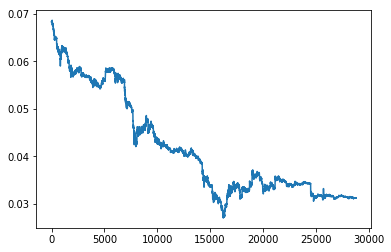

In [3]:
# matplotlibの読み込み（エラーが出た時はpip or pip3でインストール）
import matplotlib.pyplot as plt

# 一番簡単なプロット
#plt.plot(df['close'])　# この記述は正しく表示されない
plt.plot(data_original)
plt.show()

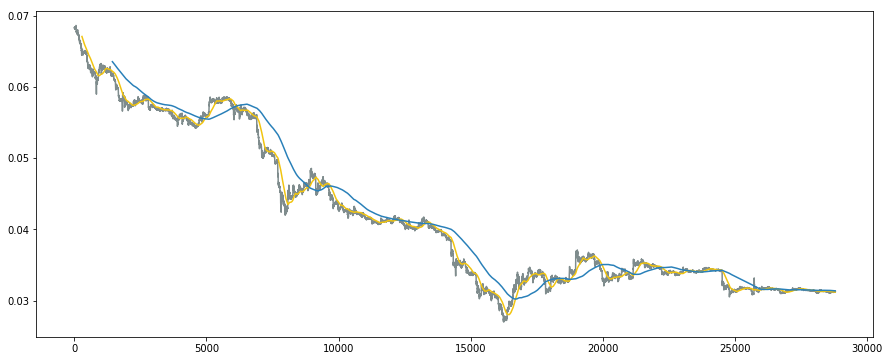

In [4]:
# 描画を綺麗に表示する
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

# プロットの色を指定しよう（color）
plt.plot(data_original, color='#7f8c8d')
plt.plot(data_s, color='#f1c40f')  # 短期線
plt.plot(data_l, color='#2980b9')  # 長期線
plt.show()

In [5]:
# 線形代数の演算でよく使うnumpyの読み込み
import numpy as np

# API経由では文字列（String型）として受け取るため、float型に変換しておく
# また、Chainerではfloat32を推奨しているため、こちらに合わせておく
#data = df['close'].astype(np.float32)　
data = data_original.astype(np.float32)

# データを入力変数xと出力変数tに切り分け
x, t = [], []
N = len(data)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
    # 入力変数と出力変数の切り分け
    _x = data[n-M: n] # 入力変数
    _t = data[n] # 出力変数
    # 計算用のリスト(x, t)に追加していく
    x.append(_x)
    t.append(_t)
    
# numpyの形式に変換する（何かと便利なため）
x = np.array(x)
t = np.array(t).reshape(len(t), 1)  # reshapeは後々のChainerでエラーが出ない対策

# 70%を訓練用、30%を検証用
N_train = int(N * 0.7)
x_train, x_test = x[:N_train], x[N_train:]
t_train, t_test = t[:N_train], t[N_train:]

# scikit-learnのlinear_modelを読み込み
from sklearn import linear_model

# 重回帰分析モデルの宣言
reg = linear_model.LinearRegression()

# 訓練データを使ったモデルの学習
reg.fit(x_train, t_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# 訓練データ
reg.score(x_train, t_train)

0.9999273524942903

In [7]:
# 訓練データ
reg.score(x_test, t_test)

0.9987938381979035

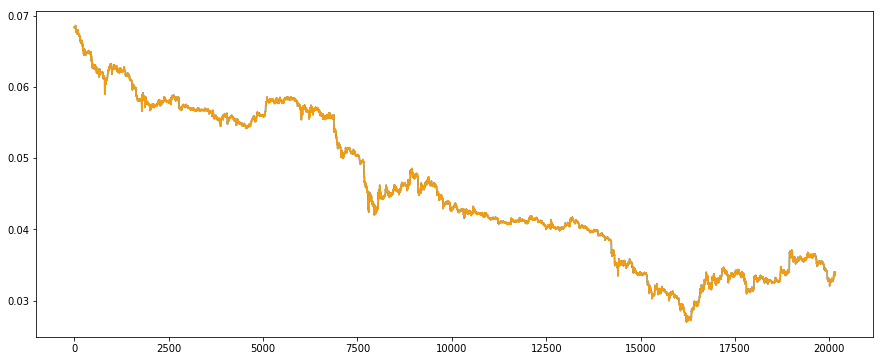

In [8]:
# 訓練データ
plt.plot(t_train, color='#2980b9')  # 実測値は青色
plt.plot(reg.predict(x_train), color='#f39c12')  # 予測値はオレンジ
plt.show()

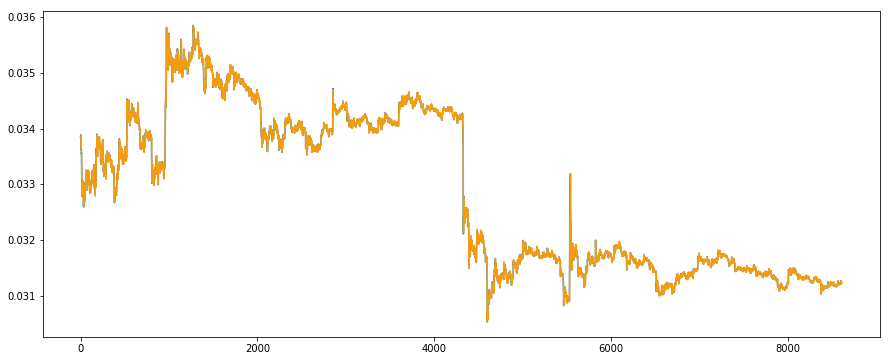

In [9]:
# 検証データ
plt.plot(t_test, color='#2980b9')  # 実測値は青色
plt.plot(reg.predict(x_test), color='#f39c12')  # 予測値はオレンジ
plt.show()

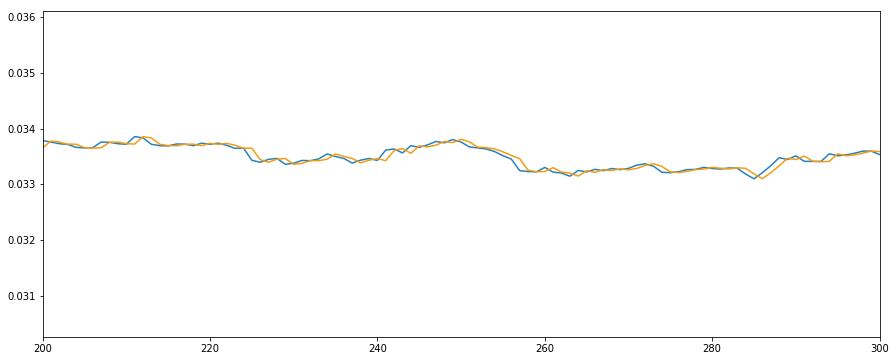

In [10]:
# 検証用の一部を見てみる
plt.plot(t_test, color='#2980b9')  # 実測値は青色
plt.plot(reg.predict(x_test), color='#f39c12')  # 予測値はオレンジ
plt.xlim(200, 300)  # 特徴がわかりやすい一部
plt.show()

C:\Users\gpbjk\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


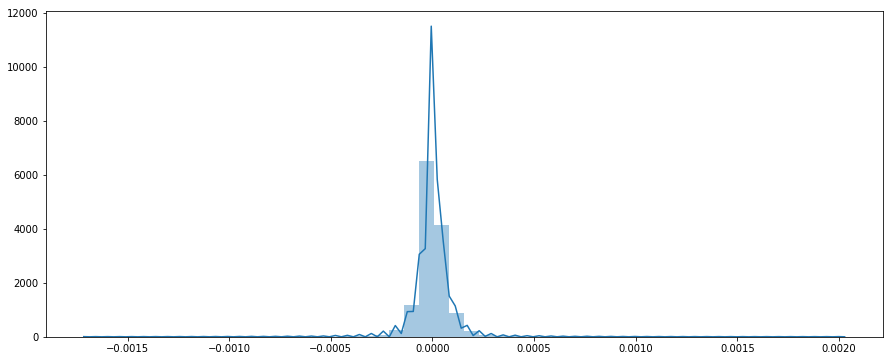

In [11]:
# 前サンプルとの差分を取る
t_diff = t[:-1] - t[1:]

# searbornのdistplotが便利
sns.distplot(t_diff)
plt.show()

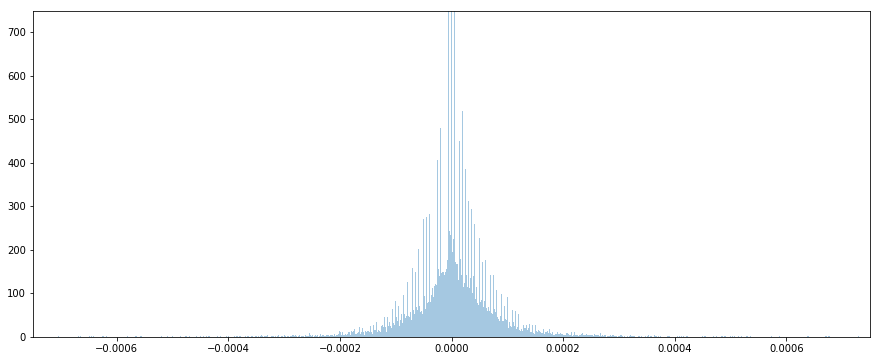

In [12]:
# binの数を増やし、kde(ガウシアンカーネル密度比推定)のプロットをオフ
sns.distplot(t_diff, bins=3000, kde=False)
plt.xlim(-0.00075, 0.00075)
plt.ylim(0, 750)
plt.show()

In [13]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions

class LSTM(Chain):
    # モデルの構造を明記
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units) # LSTMの層を追加
            self.l2 = L.Linear(None, n_output)

    # LSTM内で保持する値をリセット
    def reset_state(self):
        self.l1.reset_state()

    # 損失関数の計算
    def __call__(self, x, t, train=True):
        y = self.predict(x, train)
        loss = F.mean_squared_error(y, t)
        if train:
            report({'loss': loss}, self)
        return loss

    # 順伝播の計算
    def predict(self, x, train=False):
        # ドロップアウトの追加（訓練時のみ使うようにする）
        if train:
            h1 = F.dropout(self.l1(x), ratio=0.05)
        else:
            h1 = self.l1(x)
        h2 = self.l2(h1)
        return h2
    
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater, self).__init__(data_iter, optimizer, device=None)
        self.device = device

    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")

        batch = data_iter.__next__()
        x_batch, y_batch = chainer.dataset.concat_examples(batch, self.device)

        # ↓ ここで reset_state() を実行できるようにしている
        optimizer.target.reset_state()

        # その他は時系列系の更新と同じ
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, y_batch)
        loss.backward()
        # 時系列ではunchain_backward()によって計算効率が上がるそう
        loss.unchain_backward()
        optimizer.update()

In [14]:
# chainer用のデータセットでメモリに乗る程度であれば、list(zip(...))を推奨
# ↑ PFNの開発者推奨の方法
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))

# 再現性確保
np.random.seed(1)

# モデルの宣言
model = LSTM(30, 1)

# optimizerの定義
optimizer = optimizers.Adam()  # 最適化アルゴリズムはAdamを使用
optimizer.setup(model)

# iteratorの定義
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# updaterの定義
updater = LSTMUpdater(train_iter, optimizer)

# trainerの定義
epoch = 30
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
# trainerの拡張機能
trainer.extend(extensions.Evaluator(test_iter, model)) # 評価データで評価
trainer.extend(extensions.LogReport(trigger=(1, 'epoch'))) # 学習結果の途中を表示する
# １エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [15]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           9.85437e-06  0.00812449            1.84113       
2           1.26715e-06  0.000404059           3.66519       
3           6.18618e-07  0.00117624            5.50538       
4           5.02513e-07  0.00382894            7.81967       
5           4.46867e-07  0.00521494            10.2646       
6           4.25045e-07  0.00555499            12.0959       
7           3.8915e-07  0.00631383            14.3592       
8           3.98983e-07  0.00638969            16.5578       
9           3.76993e-07  0.00597485            18.6521       
10          3.6741e-07  0.00492063            20.8172       
11          3.39434e-07  0.00522036            22.6715       
12          3.51321e-07  0.00501852            24.5057       
13          3.56014e-07  0.00459505            26.3493       
14          3.38524e-07  0.00424358            28.193        
15          3.36428e-07  0.00518006            30.024        
16          3

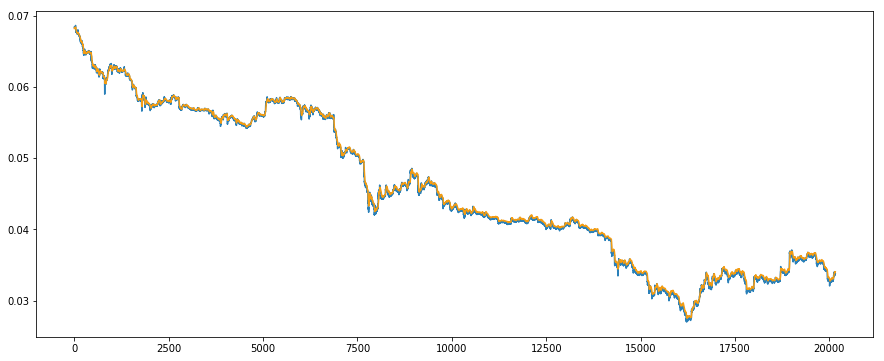

In [16]:
# 予測値の計算
model.reset_state()
y_train = model.predict(Variable(x_train)).data

# プロット
plt.plot(t_train, color='#2980b9') # 実測値は青色
plt.plot(y_train, color='#f39c12') # 予測値はオレンジ
plt.show()

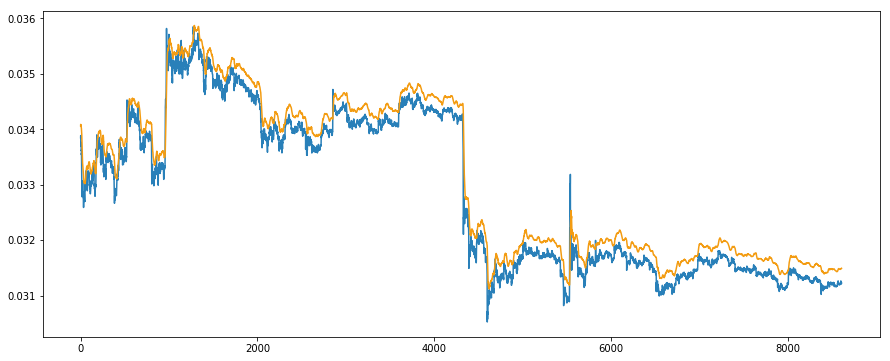

In [17]:
# 予測値の計算
model.reset_state()
y_test = model.predict(Variable(x_test)).data

# プロット
plt.plot(t_test, color='#2980b9')  # 実測値は青色
plt.plot(y_test, color='#f39c12')  # 予測値はオレンジ
plt.show()

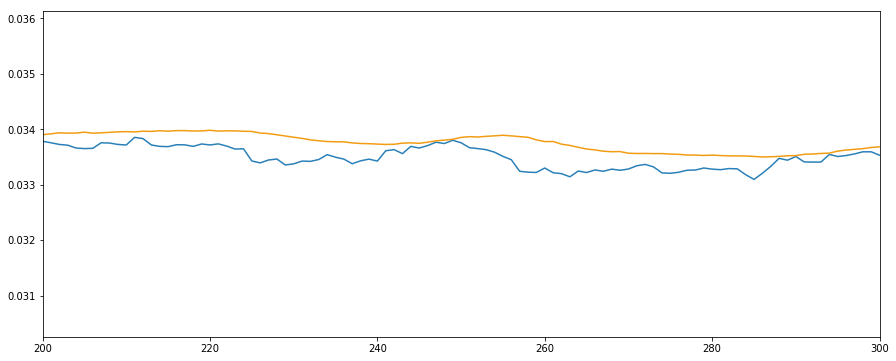

In [18]:
# 検証用の一部を見てみる
plt.plot(t_test, color='#2980b9')  # 実測値は青色
plt.plot(y_test, color='#f39c12')  # 予測値はオレンジ
plt.xlim(200, 300)  # 特徴がわかりやすい一部
plt.show()